In [25]:
import functions_exp_kernel as fn
import importlib
importlib.reload(fn)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import differential_evolution
import scipy.linalg
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score
import time
import random
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from scipy import stats

In [27]:
# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

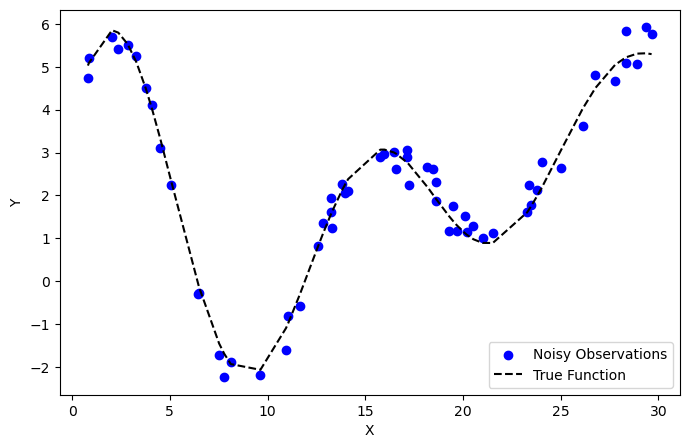

In [29]:
def ground_truth_function(x):
    return np.sin(0.5 * x) * (10 * np.log(x + 2) / x) + (x ** 2) / 200

np.random.seed(0)  
n = 60
X = np.random.uniform(0.25, 30, n)  
X = np.sort(X)
noise_variance = 0.1
noise = np.random.normal(0, np.sqrt(noise_variance), X.shape)
Y = ground_truth_function(X) + noise
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

plt.figure(figsize=(8, 5))
plt.scatter(X, Y, color='blue', label="Noisy Observations")
plt.plot(X, ground_truth_function(X), color='black', linestyle="dashed", label="True Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()


In [ ]:
np.random.seed(42)
outlier_ratio = 0.2
num_outliers = int(outlier_ratio * len(Y))
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers).reshape(-1, 1)
outlier_sign = np.random.choice([-1, 1], num_outliers).reshape(-1, 1)

Y_20 = Y.copy()
Y_20[outlier_indices] += outlier_sign * outlier_magnitude 


k = 7
nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
depth = np.zeros(len(X_scaled))
for i in range(len(X_scaled)):
    depth[i] = fn.mahalanobis_depth(Y_scaled[indices[i][1:]], Y_scaled[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X_scaled, Y_scaled, depth)
weight_depth_opt = fn.weight(1-depth, gamma, lamda)
print(f"k : {k}, gamma: {gamma}, lamda: {lamda}")
theta_DWGP, sigma_DWGP = fn.optimize_hyperparameters_weighted(X_scaled, Y_scaled, weight_depth_opt)

print(f"theta_DWGP : {theta_DWGP}, sigma2_DWGP: {sigma_DWGP**2}")


In [31]:
# Estimate best k for DWGP
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)

depth_opt_K = np.zeros((15, 2))
for k in range(5, 20):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
    distances, indices = nbrs.kneighbors(X_scaled)
    depth = np.zeros(len(X_scaled))
    for i in range(len(X_scaled)):
        depth[i] = fn.mahalanobis_depth(Y_scaled[indices[i][1:]], Y_scaled[indices[i][0]]).item()
    gamma, lamda = fn.optimize_weight_parameters(X_scaled, Y_scaled, depth)
    weight_depth_opt = fn.weight(1 - depth, gamma, lamda)
    theta, sigma = fn.optimize_hyperparameters_weighted(X_scaled, Y_scaled, weight_depth_opt)
    nll = fn.negative_log_marginal_likelihood_weighted((theta, sigma), X_scaled, Y_scaled, weight_depth_opt)
    depth_opt_K[k - 5] = [k, nll]

best_k = int(depth_opt_K[np.argmin(depth_opt_K[:, 1]), 0])
print(f"Best k for DWGP: {best_k}")

mu_s_DWGP_std, _ = fn.gp_regression_weighted(X_train_std, y_train_std, X_test_std, theta_DWGP, sigma_DWGP, weight_depth_opt)

w_D = fn.compute_robust_weights(X, Y, gamma = 0.005, r = 0.25, s = 5, eta = 0.5)

theta_RWGP, sigma_RWGP = fn.optimize_hyperparameters_weighted(X, Y, w_D)

mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train_clean, X_test, theta_RWGP, sigma_RWGP, w_D)

mu_s_SGP, _ = fn.gp_regression(X_train, y_train_clean, X_test, theta_SGP, sigma_SGP)

theta_SGP, sigma_SGP = fn.optimize_hyperparameters(X, Y)
print(f"theta : {theta_SGP}, sigma2: {sigma_SGP**2}")

Best k for DWGP: 7


In [33]:
depth_opt_K_sort = depth_opt_K[depth_opt_K[:,1].argsort()]
k = int(depth_opt_K_sort[0, 0])
nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
depth = np.zeros(len(X_scaled))
for i in range(len(X_scaled)):
    depth[i] = fn.mahalanobis_depth(Y_scaled[indices[i][1:]], Y_scaled[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X_scaled, Y_scaled, depth)
weight_depth_opt = fn.weight(1-depth, gamma, lamda)
print(f"k : {k}, gamma: {gamma}, lamda: {lamda}")
theta_DWGP, sigma_DWGP = fn.optimize_hyperparameters_weighted(X_scaled, Y_scaled, weight_depth_opt)

print(f"theta_DWGP : {theta_DWGP}, sigma2_DWGP: {sigma_DWGP**2}")

k : 7, gamma: 0.17406594307495332, lamda: 7.806020781046914
theta_DWGP : 4.9349275281382425, sigma2_DWGP: 0.007388616114137849


In [35]:
theta_SGP, sigma_SGP = fn.optimize_hyperparameters(X, Y)
print(f"theta : {theta_SGP}, sigma2: {sigma_SGP**2}")

theta : 0.11568402338683573, sigma2: 0.0879518200622299


In [37]:
w_D = fn.compute_robust_weights(X, Y, gamma = 0.005, r = 0.25, s = 5, eta = 0.5)

theta_RWGP, sigma_RWGP = fn.optimize_hyperparameters_weighted(X, Y, w_D)
print(f"theta : {theta_RWGP}, sigma2: {sigma_RWGP**2}")

theta : 0.12376629391720634, sigma2: 0.04441846390835284


In [ ]:
nbrs = NearestNeighbors(n_neighbors=best_k).fit(X_train_std)
distances, indices = nbrs.kneighbors(X_train_std)
depth = np.zeros(len(X_train_std))
for i in range(len(X_train_std)):
    depth[i] = fn.mahalanobis_depth(y_train_std[indices[i][1:]], y_train_std[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X_train_std, y_train_std, depth)
weight_depth_opt = fn.weight(1 - depth, gamma, lamda)

mu_s_DWGP_std, _ = fn.gp_regression_weighted(X_train_std, y_train_std, X_test_std, theta_DWGP, sigma_DWGP, weight_depth_opt)


In [39]:
def run_repeat_clean(repeat):
    print(f"Running repeat {repeat + 1}")
    rmse_DWGP_clean_list, rmse_RWGP_clean_list, rmse_SGP_clean_list = [], [], []

    kf = KFold(n_splits=10, shuffle=True, random_state=repeat)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train_clean = Y[train_index]
        y_test_clean = Y[test_index]

        # DWGP
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        y_train_std = scaler_y.fit_transform(y_train_clean)
        X_test_std = scaler_X.transform(X_test)

        nbrs = NearestNeighbors(n_neighbors=best_k).fit(X_train_std)
        distances, indices = nbrs.kneighbors(X_train_std)
        depth = np.zeros(len(X_train_std))
        for i in range(len(X_train_std)):
            depth[i] = fn.mahalanobis_depth(y_train_std[indices[i][1:]], y_train_std[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train_std, y_train_std, depth)
        weight_depth_opt = fn.weight(1 - depth, gamma, lamda)

        mu_s_DWGP_std, _ = fn.gp_regression_weighted(X_train_std, y_train_std, X_test_std, theta_DWGP, sigma_DWGP, weight_depth_opt)
        mu_s_DWGP = scaler_y.inverse_transform(mu_s_DWGP_std)
        rmse_DWGP_clean_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_DWGP)))

        # RWGP
        w_D = fn.compute_robust_weights(X_train, y_train_clean, gamma=0.005, r=0.5, s=5, eta=0.5)
        mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train_clean, X_test, theta_RWGP, sigma_RWGP, w_D)
        rmse_RWGP_clean_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_RWGP)))

        # SGP
        mu_s_SGP, _ = fn.gp_regression(X_train, y_train_clean, X_test, theta_SGP, sigma_SGP)
        rmse_SGP_clean_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_SGP)))

    return rmse_DWGP_clean_list, rmse_RWGP_clean_list, rmse_SGP_clean_list


# ---------- اجرا ----------
start_time = time.time()
results_clean = Parallel(n_jobs=8)(delayed(run_repeat_clean)(i) for i in range(30))

rmse_results_DWGP_clean = np.array([r[0] for r in results_clean])
rmse_results_RWGP_clean = np.array([r[1] for r in results_clean])
rmse_results_SGP_clean = np.array([r[2] for r in results_clean])

rmse_DWGP_clean = np.mean(rmse_results_DWGP_clean, axis=1)
rmse_RWGP_clean = np.mean(rmse_results_RWGP_clean, axis=1)
rmse_SGP_clean = np.mean(rmse_results_SGP_clean, axis=1)

mean_rmse_DWGP_clean = np.mean(rmse_DWGP_clean)
std_rmse_DWGP_clean = np.std(rmse_DWGP_clean)

mean_rmse_RWGP_clean = np.mean(rmse_RWGP_clean)
std_rmse_RWGP_clean = np.std(rmse_RWGP_clean)

mean_rmse_SGP_clean = np.mean(rmse_SGP_clean)
std_rmse_SGP_clean = np.std(rmse_SGP_clean)

end_time = time.time()
execution_time_clean = end_time - start_time

print(f"Execution time (clean): {execution_time_clean:.2f} seconds")
print(f"DWGP RMSE (clean): {mean_rmse_DWGP_clean:.4f} ± {std_rmse_DWGP_clean:.4f}")
print(f"RWGP RMSE (clean): {mean_rmse_RWGP_clean:.4f} ± {std_rmse_RWGP_clean:.4f}")
print(f"SGP  RMSE (clean): {mean_rmse_SGP_clean:.4f} ± {std_rmse_SGP_clean:.4f}")

print(f"Average Error Difference between DWGP_clean and RWGP_clean: {np.mean(rmse_DWGP_clean)-np.mean(rmse_RWGP_clean):.4f}")
print(f"Average Error Difference between DWGP_clean and SGP_clean: {np.mean(rmse_DWGP_clean)-np.mean(rmse_SGP_clean):.4f}")


Execution time (clean): 68.16 seconds
DWGP RMSE (clean): 0.3493 ± 0.0402
RWGP RMSE (clean): 0.4193 ± 0.0150
SGP  RMSE (clean): 0.3302 ± 0.0118
Average Error Difference between DWGP_clean and RWGP_clean: -0.0700
Average Error Difference between DWGP_clean and SGP_clean: 0.0191


In [41]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_clean, rmse_RWGP_clean)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -9.068398223362315
P-value: 5.780900614004995e-10


In [43]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_clean, rmse_SGP_clean)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 2.5889174993113557
P-value: 0.014897371879448233


In [45]:
# ----------5% Contamination----------
np.random.seed(42)
outlier_ratio = 0.05
num_outliers = int(outlier_ratio * len(Y))
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers).reshape(-1, 1)
outlier_sign = np.random.choice([-1, 1], num_outliers).reshape(-1, 1)

Y_5 = Y.copy()
Y_5[outlier_indices] += outlier_sign * outlier_magnitude 

def run_repeat_5percent(repeat):
    print(f"Running repeat {repeat + 1}")
    rmse_DWGP_5_list, rmse_RWGP_5_list, rmse_SGP_5_list = [], [], []

    kf = KFold(n_splits=10, shuffle=True, random_state=repeat)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train_5 = Y_5[train_index] 
        y_test_clean = Y[test_index] 

        # DWGP
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        y_train_std = scaler_y.fit_transform(y_train_5)
        X_test_std = scaler_X.transform(X_test)

        nbrs = NearestNeighbors(n_neighbors=best_k).fit(X_train_std)
        distances, indices = nbrs.kneighbors(X_train_std)
        depth = np.zeros(len(X_train_std))
        for i in range(len(X_train_std)):
            depth[i] = fn.mahalanobis_depth(y_train_std[indices[i][1:]], y_train_std[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train_std, y_train_std, depth)
        weight_depth_opt = fn.weight(1 - depth, gamma, lamda)

        mu_s_DWGP_std, _ = fn.gp_regression_weighted(X_train_std, y_train_std, X_test_std, theta_DWGP, sigma_DWGP, weight_depth_opt)
        mu_s_DWGP = scaler_y.inverse_transform(mu_s_DWGP_std)
        rmse_DWGP_5_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_DWGP)))

        # RWGP
        w_D = fn.compute_robust_weights(X_train, y_train_5, gamma=0.005, r=0.5, s=5, eta=0.5)
        mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train_5, X_test, theta_RWGP, sigma_RWGP, w_D)
        rmse_RWGP_5_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_RWGP)))

        # SGP
        mu_s_SGP, _ = fn.gp_regression(X_train, y_train_5, X_test, theta_SGP, sigma_SGP)
        rmse_SGP_5_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_SGP)))

    return rmse_DWGP_5_list, rmse_RWGP_5_list, rmse_SGP_5_list

start_time = time.time()
results_5 = Parallel(n_jobs=8)(delayed(run_repeat_5percent)(i) for i in range(30))

rmse_results_DWGP_5 = np.array([r[0] for r in results_5])
rmse_results_RWGP_5 = np.array([r[1] for r in results_5])
rmse_results_SGP_5 = np.array([r[2] for r in results_5])

rmse_DWGP_5 = np.mean(rmse_results_DWGP_5, axis=1)

mean_rmse_DWGP_5 = np.mean(rmse_DWGP_5)
std_rmse_DWGP_5 = np.std(rmse_DWGP_5)

rmse_RWGP_5 = np.mean(rmse_results_RWGP_5, axis=1)

mean_rmse_RWGP_5 = np.mean(rmse_RWGP_5)
std_rmse_RWGP_5 = np.std(rmse_RWGP_5)


rmse_SGP_5 = np.mean(rmse_results_SGP_5, axis=1)

mean_rmse_SGP_5 = np.mean(rmse_SGP_5)
std_rmse_SGP_5 = np.std(rmse_SGP_5)

end_time = time.time()
execution_time_5 = end_time - start_time

print(f"Execution time (5%): {execution_time_5:.2f} seconds")
print(f"DWGP RMSE (5%): {mean_rmse_DWGP_5:.4f} ± {std_rmse_DWGP_5:.4f}")
print(f"RWGP RMSE (5%): {mean_rmse_RWGP_5:.4f} ± {std_rmse_RWGP_5:.4f}")
print(f"SGP  RMSE (5%): {mean_rmse_SGP_5:.4f} ± {std_rmse_SGP_5:.4f}")

print(f"Average Error Difference between DWGP_5 and RWGP_5: {np.mean(rmse_DWGP_5)-np.mean(rmse_RWGP_5):.4f}")
print(f"Average Error Difference between DWGP_5 and SGP_5: {np.mean(rmse_DWGP_5)-np.mean(rmse_SGP_5):.4f}")

Execution time (5%): 44.31 seconds
DWGP RMSE (5%): 0.3573 ± 0.0149
RWGP RMSE (5%): 0.4177 ± 0.0239
SGP  RMSE (5%): 0.7292 ± 0.0376
Average Error Difference between DWGP_5 and RWGP_5: -0.0603
Average Error Difference between DWGP_5 and SGP_5: -0.3719


In [47]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_5, rmse_RWGP_5)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -15.186472195894424
P-value: 2.4413120145710165e-15


In [49]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_5, rmse_SGP_5)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -52.15690077793664
P-value: 3.199664602597436e-30


In [51]:
# ----------10% Contamination---------
np.random.seed(42)
outlier_ratio = 0.10
num_outliers = int(outlier_ratio * len(Y))
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers).reshape(-1, 1)
outlier_sign = np.random.choice([-1, 1], num_outliers).reshape(-1, 1)

Y_10 = Y.copy()
Y_10[outlier_indices] += outlier_sign * outlier_magnitude  

def run_repeat_10percent(repeat):
    print(f"Running repeat {repeat + 1}")
    rmse_DWGP_10_list, rmse_RWGP_10_list, rmse_SGP_10_list = [], [], []

    kf = KFold(n_splits=10, shuffle=True, random_state=repeat)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train_10 = Y_10[train_index]  
        y_test_clean = Y[test_index]    

        # DWGP
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        y_train_std = scaler_y.fit_transform(y_train_10)
        X_test_std = scaler_X.transform(X_test)

        nbrs = NearestNeighbors(n_neighbors=best_k).fit(X_train_std)
        distances, indices = nbrs.kneighbors(X_train_std)
        depth = np.zeros(len(X_train_std))
        for i in range(len(X_train_std)):
            depth[i] = fn.mahalanobis_depth(y_train_std[indices[i][1:]], y_train_std[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train_std, y_train_std, depth)
        weight_depth_opt = fn.weight(1 - depth, gamma, lamda)

        mu_s_DWGP_std, _ = fn.gp_regression_weighted(X_train_std, y_train_std, X_test_std, theta_DWGP, sigma_DWGP, weight_depth_opt)
        mu_s_DWGP = scaler_y.inverse_transform(mu_s_DWGP_std)
        rmse_DWGP_10_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_DWGP)))

        # RWGP
        w_D = fn.compute_robust_weights(X_train, y_train_10, gamma=0.005, r=0.5, s=5, eta=0.5)
        mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train_10, X_test, theta_RWGP, sigma_RWGP, w_D)
        rmse_RWGP_10_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_RWGP)))

        # SGP
        mu_s_SGP, _ = fn.gp_regression(X_train, y_train_10, X_test, theta_SGP, sigma_SGP)
        rmse_SGP_10_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_SGP)))

    return rmse_DWGP_10_list, rmse_RWGP_10_list, rmse_SGP_10_list

# -------------------
start_time = time.time()
results_10 = Parallel(n_jobs=8)(delayed(run_repeat_10percent)(i) for i in range(30))

rmse_results_DWGP_10 = np.array([r[0] for r in results_10])
rmse_results_RWGP_10 = np.array([r[1] for r in results_10])
rmse_results_SGP_10 = np.array([r[2] for r in results_10])


rmse_DWGP_10 = np.mean(rmse_results_DWGP_10, axis=1)

mean_rmse_DWGP_10 = np.mean(rmse_DWGP_10)
std_rmse_DWGP_10 = np.std(rmse_DWGP_10)

rmse_RWGP_10 = np.mean(rmse_results_RWGP_10, axis=1)

mean_rmse_RWGP_10 = np.mean(rmse_RWGP_10)
std_rmse_RWGP_10 = np.std(rmse_RWGP_10)


rmse_SGP_10 = np.mean(rmse_results_SGP_10, axis=1)

mean_rmse_SGP_10 = np.mean(rmse_SGP_10)
std_rmse_SGP_10 = np.std(rmse_SGP_10)

end_time = time.time()
execution_time_10 = end_time - start_time

print(f"Execution time (10%): {execution_time_10:.2f} seconds")
print(f"DWGP RMSE (10%): {mean_rmse_DWGP_10:.4f} ± {std_rmse_DWGP_10:.4f}")
print(f"RWGP RMSE (10%): {mean_rmse_RWGP_10:.4f} ± {std_rmse_RWGP_10:.4f}")
print(f"SGP  RMSE (10%): {mean_rmse_SGP_10:.4f} ± {std_rmse_SGP_10:.4f}")

print(f"Average Error Difference between DWGP_10 and RWGP_10: {np.mean(rmse_DWGP_10)-np.mean(rmse_RWGP_10):.4f}")
print(f"Average Error Difference between DWGP_10 and SGP_10: {np.mean(rmse_DWGP_10)-np.mean(rmse_SGP_10):.4f}")

Execution time (10%): 46.84 seconds
DWGP RMSE (10%): 0.3778 ± 0.0177
RWGP RMSE (10%): 0.4248 ± 0.0603
SGP  RMSE (10%): 1.1747 ± 0.0380
Average Error Difference between DWGP_10 and RWGP_10: -0.0470
Average Error Difference between DWGP_10 and SGP_10: -0.7969


In [53]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_10, rmse_RWGP_10)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -4.7273358484603945
P-value: 5.4098480901130945e-05


In [55]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_10, rmse_SGP_10)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -109.25613453402761
P-value: 1.7460325556590265e-39


In [57]:
# ----------15% Contamination----------
np.random.seed(42)
outlier_ratio = 0.15
num_outliers = int(outlier_ratio * len(Y))
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers).reshape(-1, 1)
outlier_sign = np.random.choice([-1, 1], num_outliers).reshape(-1, 1)

Y_15 = Y.copy()
Y_15[outlier_indices] += outlier_sign * outlier_magnitude  


def run_repeat_15percent(repeat):
    print(f"Running repeat {repeat + 1}")
    rmse_DWGP_15_list, rmse_RWGP_15_list, rmse_SGP_15_list = [], [], []

    kf = KFold(n_splits=10, shuffle=True, random_state=repeat)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train_15 = Y_15[train_index]     
        y_test_clean = Y[test_index]       

        # DWGP
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        y_train_std = scaler_y.fit_transform(y_train_15)
        X_test_std = scaler_X.transform(X_test)

        nbrs = NearestNeighbors(n_neighbors=best_k).fit(X_train_std)
        distances, indices = nbrs.kneighbors(X_train_std)
        depth = np.zeros(len(X_train_std))
        for i in range(len(X_train_std)):
            depth[i] = fn.mahalanobis_depth(y_train_std[indices[i][1:]], y_train_std[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train_std, y_train_std, depth)
        weight_depth_opt = fn.weight(1 - depth, gamma, lamda)

        mu_s_DWGP_std, _ = fn.gp_regression_weighted(X_train_std, y_train_std, X_test_std, theta_DWGP, sigma_DWGP, weight_depth_opt)
        mu_s_DWGP = scaler_y.inverse_transform(mu_s_DWGP_std)
        rmse_DWGP_15_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_DWGP)))

        # RWGP
        w_D = fn.compute_robust_weights(X_train, y_train_15, gamma=0.005, r=0.5, s=5, eta=0.5)
        mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train_15, X_test, theta_RWGP, sigma_RWGP, w_D)
        rmse_RWGP_15_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_RWGP)))

        # SGP
        mu_s_SGP, _ = fn.gp_regression(X_train, y_train_15, X_test, theta_SGP, sigma_SGP)
        rmse_SGP_15_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_SGP)))

    return rmse_DWGP_15_list, rmse_RWGP_15_list, rmse_SGP_15_list

# -------------------
start_time = time.time()
results_15 = Parallel(n_jobs=8)(delayed(run_repeat_15percent)(i) for i in range(30))

rmse_results_DWGP_15 = np.array([r[0] for r in results_15])
rmse_results_RWGP_15 = np.array([r[1] for r in results_15])
rmse_results_SGP_15 = np.array([r[2] for r in results_15])

rmse_DWGP_15 = np.mean(rmse_results_DWGP_15, axis=1)

mean_rmse_DWGP_15 = np.mean(rmse_DWGP_15)
std_rmse_DWGP_15 = np.std(rmse_DWGP_15)

rmse_RWGP_15 = np.mean(rmse_results_RWGP_15, axis=1)

mean_rmse_RWGP_15 = np.mean(rmse_RWGP_15)
std_rmse_RWGP_15 = np.std(rmse_RWGP_15)


rmse_SGP_15 = np.mean(rmse_results_SGP_15, axis=1)

mean_rmse_SGP_15 = np.mean(rmse_SGP_15)
std_rmse_SGP_15 = np.std(rmse_SGP_15)

end_time = time.time()
execution_time_15 = end_time - start_time


print(f"Execution time (15%): {execution_time_15:.2f} seconds")
print(f"DWGP RMSE (15%): {mean_rmse_DWGP_15:.4f} ± {std_rmse_DWGP_15:.4f}")
print(f"RWGP RMSE (15%): {mean_rmse_RWGP_15:.4f} ± {std_rmse_RWGP_15:.4f}")
print(f"SGP  RMSE (15%): {mean_rmse_SGP_15:.4f} ± {std_rmse_SGP_15:.4f}")

print(f"Average Error Difference between DWGP_15 and RWGP_15: {np.mean(rmse_DWGP_15)-np.mean(rmse_RWGP_15):.4f}")
print(f"Average Error Difference between DWGP_15 and SGP_15: {np.mean(rmse_DWGP_15)-np.mean(rmse_SGP_15):.4f}")


Execution time (15%): 33.80 seconds
DWGP RMSE (15%): 0.4526 ± 0.0549
RWGP RMSE (15%): 0.7186 ± 0.0856
SGP  RMSE (15%): 1.5803 ± 0.0649
Average Error Difference between DWGP_15 and RWGP_15: -0.2660
Average Error Difference between DWGP_15 and SGP_15: -1.1277


In [59]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_15, rmse_RWGP_15)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -15.844968333625241
P-value: 8.103865739201406e-16


In [61]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_15, rmse_SGP_15)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -77.4006882389748
P-value: 3.7045900697038724e-35


In [63]:
# ----------20% Contamination ---------
np.random.seed(42)
outlier_ratio = 0.2
num_outliers = int(outlier_ratio * len(Y))
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers).reshape(-1, 1)
outlier_sign = np.random.choice([-1, 1], num_outliers).reshape(-1, 1)

Y_20 = Y.copy()
Y_20[outlier_indices] += outlier_sign * outlier_magnitude 


def run_repeat_20percent(repeat):
    print(f"Running repeat {repeat + 1}")
    rmse_DWGP_20_list, rmse_RWGP_20_list, rmse_SGP_20_list = [], [], []

    kf = KFold(n_splits=10, shuffle=True, random_state=repeat)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train_20 = Y_20[train_index]    
        y_test_clean = Y[test_index]       

        # DWGP
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        y_train_std = scaler_y.fit_transform(y_train_20)
        X_test_std = scaler_X.transform(X_test)

        nbrs = NearestNeighbors(n_neighbors=best_k).fit(X_train_std)
        distances, indices = nbrs.kneighbors(X_train_std)
        depth = np.zeros(len(X_train_std))
        for i in range(len(X_train_std)):
            depth[i] = fn.mahalanobis_depth(y_train_std[indices[i][1:]], y_train_std[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train_std, y_train_std, depth)
        weight_depth_opt = fn.weight(1 - depth, gamma, lamda)

        mu_s_DWGP_std, _ = fn.gp_regression_weighted(X_train_std, y_train_std, X_test_std, theta_DWGP, sigma_DWGP, weight_depth_opt)
        mu_s_DWGP = scaler_y.inverse_transform(mu_s_DWGP_std)
        rmse_DWGP_20_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_DWGP)))

        # RWGP
        w_D = fn.compute_robust_weights(X_train, y_train_20, gamma=0.005, r=0.5, s=5, eta=0.5)
        mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train_20, X_test, theta_RWGP, sigma_RWGP, w_D)
        rmse_RWGP_20_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_RWGP)))

        # SGP
        mu_s_SGP, _ = fn.gp_regression(X_train, y_train_20, X_test, theta_SGP, sigma_SGP)
        rmse_SGP_20_list.append(np.sqrt(mean_squared_error(y_test_clean, mu_s_SGP)))

    return rmse_DWGP_20_list, rmse_RWGP_20_list, rmse_SGP_20_list

start_time = time.time()
results_20 = Parallel(n_jobs=8)(delayed(run_repeat_20percent)(i) for i in range(30))

rmse_results_DWGP_20 = np.array([r[0] for r in results_20])
rmse_results_RWGP_20 = np.array([r[1] for r in results_20])
rmse_results_SGP_20 = np.array([r[2] for r in results_20])

rmse_DWGP_20 = np.mean(rmse_results_DWGP_20, axis=1)

mean_rmse_DWGP_20 = np.mean(rmse_DWGP_20)
std_rmse_DWGP_20 = np.std(rmse_DWGP_20)

rmse_RWGP_20 = np.mean(rmse_results_RWGP_20, axis=1)

mean_rmse_RWGP_20 = np.mean(rmse_RWGP_20)
std_rmse_RWGP_20 = np.std(rmse_RWGP_20)


rmse_SGP_20 = np.mean(rmse_results_SGP_20, axis=1)

mean_rmse_SGP_20 = np.mean(rmse_SGP_20)
std_rmse_SGP_20 = np.std(rmse_SGP_20)

end_time = time.time()
execution_time_20 = end_time - start_time

print(f"Execution time (20%): {execution_time_20:.2f} seconds")
print(f"DWGP RMSE (20%): {mean_rmse_DWGP_20:.4f} ± {std_rmse_DWGP_20:.4f}")
print(f"RWGP RMSE (20%): {mean_rmse_RWGP_20:.4f} ± {std_rmse_RWGP_20:.4f}")
print(f"SGP  RMSE (20%): {mean_rmse_SGP_20:.4f} ± {std_rmse_SGP_20:.4f}")

print(f"Average Error Difference between DWGP_20 and RWGP_20: {np.mean(rmse_DWGP_20)-np.mean(rmse_RWGP_20):.4f}")
print(f"Average Error Difference between DWGP_20 and SGP_20: {np.mean(rmse_DWGP_20)-np.mean(rmse_SGP_20):.4f}")



Execution time (20%): 38.28 seconds
DWGP RMSE (20%): 0.4781 ± 0.0396
RWGP RMSE (20%): 0.7166 ± 0.0821
SGP  RMSE (20%): 1.6159 ± 0.0702
Average Error Difference between DWGP_20 and RWGP_20: -0.2385
Average Error Difference between DWGP_20 and SGP_20: -1.1378


In [65]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_20, rmse_RWGP_20)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -15.635548021006446
P-value: 1.1462112742956333e-15


In [67]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_20, rmse_SGP_20)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -81.39344481460768
P-value: 8.670754102835827e-36
